# Homework 10

## Problem 1. 30 POINTS
Create a bash shell script that will create a sqlite database of the 4 csv files in this directory. Make sure that you assing meaningful data types and constraints to your database.

In [65]:
%%bash
cat > createsql.sh<<EOF
#!/bin/bash

sqlite3 mydata.db <<EOF

CREATE TABLE billing (
billingid INT NOT NULL PRIMARY KEY,
encounterid INT NOT NULL,
code CHAR(5) NOT NULL);

CREATE TABLE encounter (
encounterid INT NOT NULL PRIMARY KEY,
patientid INT NOT NULL,
encounterdate DATE NOT NULL,
encounterphysician INT NOT NULL,
encounterreason CHAR(12) NOT NULL,
billingamount REAL NOT NULL);

CREATE TABLE patient (
patientid INT NOT NULL PRIMARY KEY,
lastname CHAR(8) NOT NULL,
firstname CHAR(8) NOT NULL,
gender CHAR(3) NOT NULL,
DOB DATE NOT NULL);

CREATE TABLE physician (
physicianid INT NOT NULL PRIMARY KEY,
lastname CHAR(12) NOT NULL,
firstname CHAR(6) NOT NULL,
specialty CHAR(12) NOT NULL);

.mode csv

.import billing.csv billing
.import encounter.csv encounter
.import patient.csv patient
.import physician.csv physician

EOF
chmod 777 createsql.sh

In [66]:
%%bash
./createsql.sh

In [74]:
%%bash
ls -al
sqlite3 mydata.db
.table
select * from patient;
select * from billing;

total 208
drwxr-xr-x  10 zhoukaile  staff    340 Nov 26 16:27 .
drwxr-xr-x  13 zhoukaile  staff    442 Nov 23 17:13 ..
drwxr-xr-x   3 zhoukaile  staff    102 Nov 23 17:33 .ipynb_checkpoints
-rw-r--r--   1 zhoukaile  staff  46843 Nov 26 16:27 Homework10.ipynb
-rw-r--r--@  1 zhoukaile  staff    241 Nov 23 17:13 billing.csv
-rwxrwxrwx   1 zhoukaile  staff    805 Nov 24 15:54 createsql.sh
-rw-r--r--@  1 zhoukaile  staff    368 Nov 23 17:13 encounter.csv
-rw-r--r--   1 zhoukaile  staff  36864 Nov 24 15:54 mydata.db
-rw-r--r--@  1 zhoukaile  staff    152 Nov 23 17:13 patient.csv
-rw-r--r--@  1 zhoukaile  staff    141 Nov 23 17:13 physician.csv
billing    encounter  patient    physician
﻿patientid|lastname|firstname|gender|dob
1|doe|john|m|2/3/63
2|doe|jane|f|7/23/71
3|sickly|joseph|m|4/2/81
4|well|sally|f|8/17/87
5|daily|bob|m|9/2/91
﻿billingid|encounterid|code
1|1|54321
2|1|54322
3|2|78634
4|3|23847
5|4|78645
6|5|22211
7|5|30000
8|5|46352
9|5|45221
10|6|10001
11|7|42222
12|8|75533
13|8|2346

## Problem 2. 30 POINTS.
Using python, answer the following questions:
    1. Provide code that creates a pandas dataframe that contains a patient-level dataset with:
        - LastName
        - FirstName
        - Total Billing Amount
    2. The billing department needs to modify each billing statment so that we take the total billing amount for each person, multiply it by 4.2 and subtract 10. Create a new column on your pandas dataframe that applies this correction and name this variable `correction`.
    3. For all patients less than 40 years old, create a pandas data frame that contains:
        - LastName
        - FirstName
        - physician last name
        - physician first name
        - total times seen that physician
    

In [1]:
# 1. create a pandas dataframe 
from sqlalchemy import create_engine
import pandas as pd
engine = create_engine('sqlite:///mydata.db')
patient = pd.read_sql("select patientid, lastname, firstname from patient;", engine)
billing = pd.read_sql("select patientid, billingamount from encounter;", engine)
df = pd.merge(patient, billing, on="patientid").drop("patientid", axis=1)

In [85]:
df.head()

,lastname,firstname,billingamount
0,doe,john,99.32
1,doe,john,87.65
2,sickly,joseph,100.01
3,sickly,joseph,43.76
4,sickly,joseph,553.23


In [86]:
# 2. add new column
df["correction"] = 4.2*df.groupby(['lastname','firstname'])["billingamount"].transform('sum')- 10


In [87]:
df.head()

,lastname,firstname,billingamount,correction
0,doe,john,99.32,775.274
1,doe,john,87.65,775.274
2,sickly,joseph,100.01,3720.020
3,sickly,joseph,43.76,3720.020
4,sickly,joseph,553.23,3720.020


In [88]:
# 3. less than 40 years
encounter = pd.read_sql("select encounterid, patientid, encounterphysician from encounter;", engine).drop(0)
patient = pd.read_sql("select patientid, lastname, firstname, DOB from patient;", engine).drop(0)
physician = pd.read_sql("select physicianid, lastname, firstname from physician;", engine).drop(0)

In [89]:
physician.rename(columns={"lastname":"physician last name", "firstname":"physician first name"}, inplace=True)
physician.head()

,physicianid,physician last name,physician first name
1,1,whitecoat,bill
2,2,satterwhite,jill
3,3,na,li
4,4,wei,liu


In [90]:
patenc = pd.merge(patient, encounter, on= 'patientid', how='outer')

In [91]:
patencphy = pd.merge(patenc, physician, left_on='encounterphysician', right_on='physicianid', how='outer')

In [92]:
patencphy.head()

,patientid,lastname,firstname,DOB,encounterid,encounterphysician,physicianid,physician last name,physician first name
0,1,doe,john,2/3/63,1,1,1,whitecoat,bill
1,3,sickly,joseph,4/2/81,10,1,1,whitecoat,bill
2,1,doe,john,2/3/63,9,2,2,satterwhite,jill
3,5,daily,bob,9/2/91,7,2,2,satterwhite,jill
4,2,doe,jane,7/23/71,NaN,NaN,NaN,NaN,NaN


In [93]:
## convert date mm/dd/yy to yyyy-mm-dd
patencphy.DOB = pd.to_datetime(patencphy.DOB)
patencphy.DOB = patencphy['DOB'].mask(patencphy['DOB'].dt.year > 2018, 
                                         patencphy['DOB'] - pd.offsets.DateOffset(years=100))
patencphy.head()

,patientid,lastname,firstname,DOB,encounterid,encounterphysician,physicianid,physician last name,physician first name
0,1,doe,john,1963-02-03,1,1,1,whitecoat,bill
1,3,sickly,joseph,1981-04-02,10,1,1,whitecoat,bill
2,1,doe,john,1963-02-03,9,2,2,satterwhite,jill
3,5,daily,bob,1991-09-02,7,2,2,satterwhite,jill
4,2,doe,jane,1971-07-23,NaN,NaN,NaN,NaN,NaN


In [105]:
## select age < 40 
patencphy = patencphy[patencphy.DOB > pd.to_datetime('11/24/78')]
patencphy.head()

,patientid,lastname,firstname,DOB,encounterid,encounterphysician,physicianid,physician last name,physician first name
1,3,sickly,joseph,1981-04-02,10,1,1,whitecoat,bill
3,5,daily,bob,1991-09-02,7,2,2,satterwhite,jill
5,4,well,sally,1987-08-17,NaN,NaN,NaN,NaN,NaN
6,3,sickly,joseph,1981-04-02,2,4,4,wei,liu
7,3,sickly,joseph,1981-04-02,3,4,4,wei,liu


In [113]:
enctimes = patencphy.filter(items=['patientid','lastname','firstname','physicianid','physician last name','physician first name'])
enctimes

,patientid,lastname,firstname,physicianid,physician last name,physician first name
1,3,sickly,joseph,1,whitecoat,bill
3,5,daily,bob,2,satterwhite,jill
5,4,well,sally,NaN,NaN,NaN
6,3,sickly,joseph,4,wei,liu
7,3,sickly,joseph,4,wei,liu
8,3,sickly,joseph,3,na,li
9,3,sickly,joseph,3,na,li
10,3,sickly,joseph,3,na,li
11,5,daily,bob,3,na,li


In [114]:
enctimes['total times seen that physician'] = enctimes.groupby(['patientid','physicianid'])['physicianid'].transform('count')

In [115]:
enctimes = enctimes.drop_duplicates().drop(['patientid','physicianid'],axis=1)
enctimes

,lastname,firstname,physician last name,physician first name,total times seen that physician
1,sickly,joseph,whitecoat,bill,1.0
3,daily,bob,satterwhite,jill,1.0
5,well,sally,NaN,NaN,NaN
6,sickly,joseph,wei,liu,2.0
8,sickly,joseph,na,li,3.0
11,daily,bob,na,li,1.0


## Problem 1. 15 POINTS
You should have received an email that contains:
    - host
    - user
    - password
    
Go ahead and create three environment variables that hold this information. From this point forward, if you need this information, you should refer to the environment variables and NOT the values themselves. You will lose all points, if the values themselves are in the code and submitted to github. You will have effectively disclosed very sensitive data. **NOTE**, there is no code you turn in to get points for this problem. Rather, I will know that you have done this by reviewing the code below.

## Problem 2. 5 POINTS
Create a `sqlalchemy` engine that is connected to our database. **NOTE** use the environment variables set up in problem 1 to do this. There should be NO host, username, or passwords visible if you are using environment variables correctly. You may receive some `ImportError`. You will need to figure out how to resolve these issues.

In [ ]:
## install psycopg2
## export user=****
## export password=****
## export host=****

In [2]:
import os
myengine = create_engine("postgresql://"+os.getenv("user")+":"+os.getenv("password")+"@"+os.getenv("host"))

TypeError: must be str, not NoneType

## Problem 3. 20 POINTS
Using the engine created in Problem 2. Use sqlalchemy to help you create a hand drawn ER diagram. Please find a way to get you hand-drawn ER diagram into this repository. HINT, if you take a picture with your phone, you can use that image (which is just a file) to put into this directory.

In [69]:
from sqlalchemy.schema import MetaData
meta = MetaData()
meta.reflect(bind=myengine)

In [71]:
for table in meta.tables.values():
    print('*********')
    print('table:' + table.name)
    print('columns:')
    for column in table.c:
        print('\t'+column.name)
        

*********
table:patient
columns:
	patientid
	lastname
	firstname
	gender
	dob
*********
table:physician
columns:
	physicianid
	lastname
	firstname
	specialty
*********
table:encounter
columns:
	encounterid
	patientid
	encounterdate
	encounterphysician
	encounterreason
	billingamount
*********
table:billing
columns:
	billingid
	encounterid
	code


In [73]:
meta.sorted_tables

[Table('patient', MetaData(bind=None), Column('patientid', INTEGER(), table=<patient>, primary_key=True, nullable=False, server_default=DefaultClause(<sqlalchemy.sql.elements.TextClause object at 0x10fd68d68>, for_update=False)), Column('lastname', VARCHAR(length=50), table=<patient>), Column('firstname', VARCHAR(length=50), table=<patient>), Column('gender', VARCHAR(length=1), table=<patient>), Column('dob', DATE(), table=<patient>), schema=None),
 Table('physician', MetaData(bind=None), Column('physicianid', INTEGER(), table=<physician>, primary_key=True, nullable=False, server_default=DefaultClause(<sqlalchemy.sql.elements.TextClause object at 0x10fca3d68>, for_update=False)), Column('lastname', VARCHAR(length=50), table=<physician>), Column('firstname', VARCHAR(length=50), table=<physician>), Column('specialty', VARCHAR(length=50), table=<physician>), schema=None),
 Table('encounter', MetaData(bind=None), Column('encounterid', INTEGER(), table=<encounter>, primary_key=True, nullabl

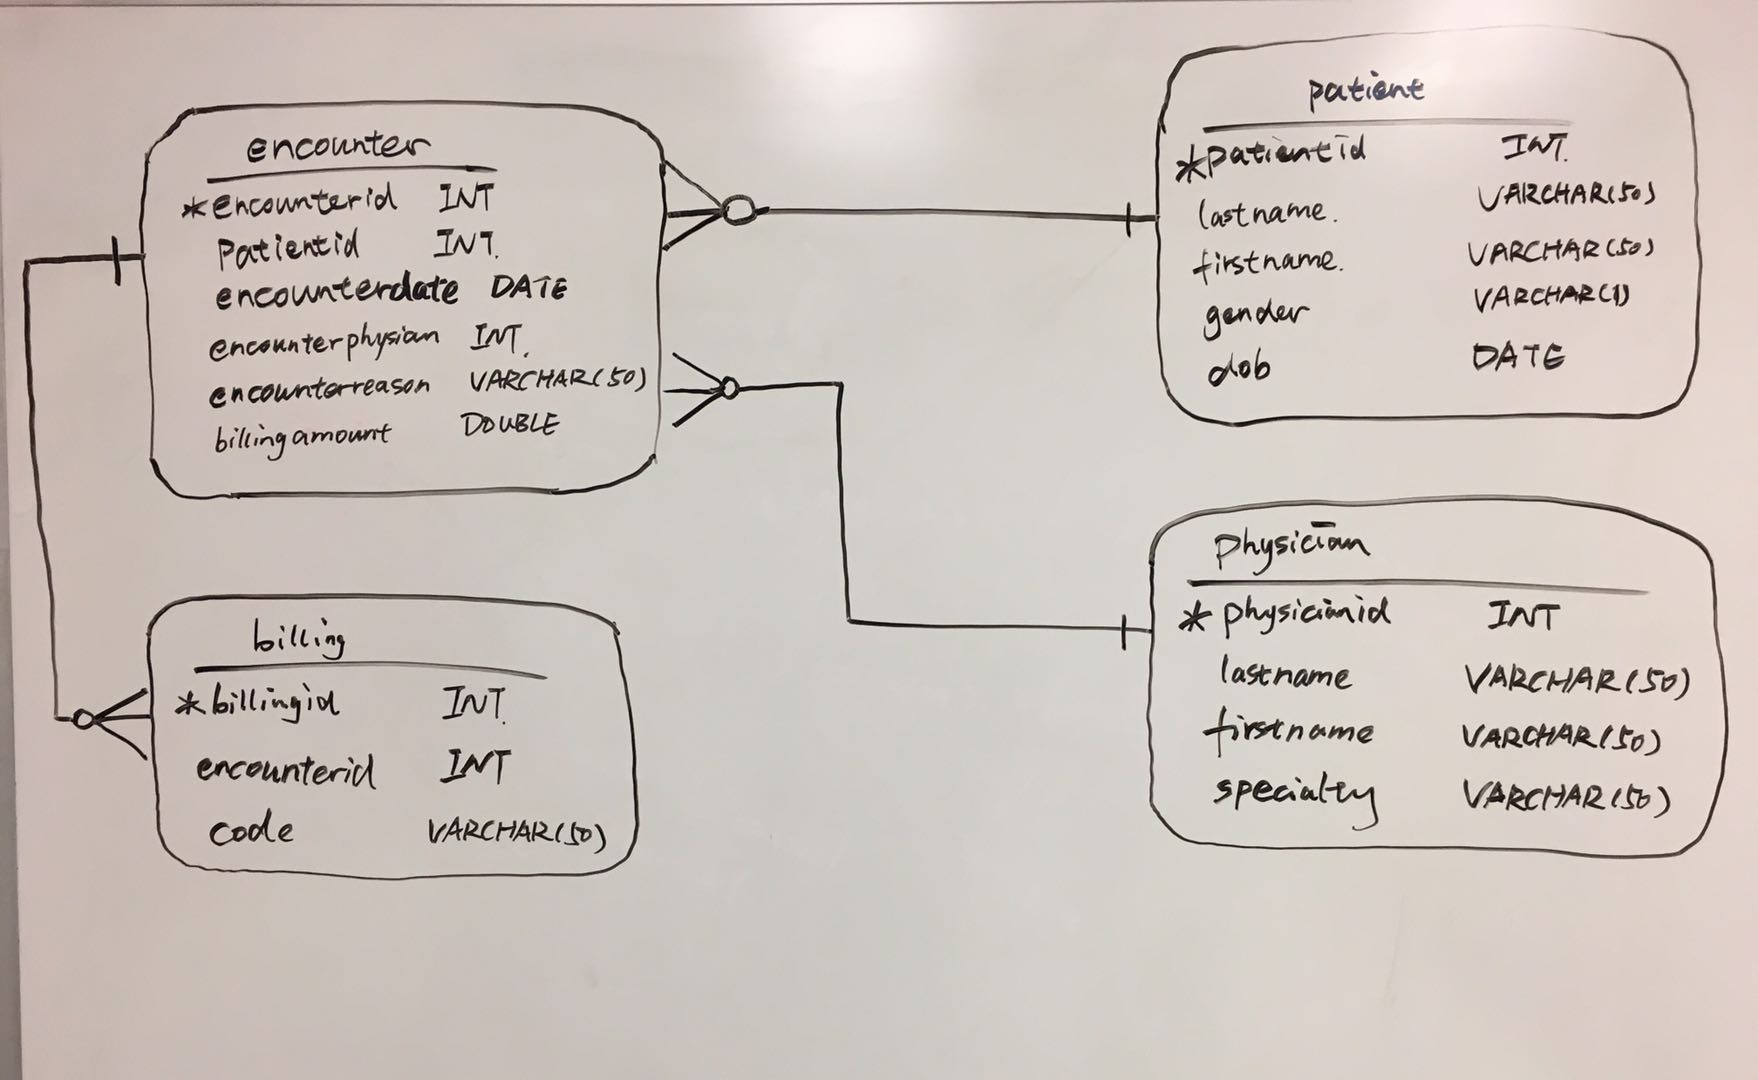

In [4]:
from IPython.display import Image
Image(filename='ER diagram.jpeg')